# Transformer first
### 1. 导入包,打印信息

In [88]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as f
import math, copy
import matplotlib.pyplot as plt


In [89]:
print(f'torch version: {torch.__version__}')
print(f'numpy version: {np.__version__}')
print(f'cuda version: {torch.version.cuda}')
print(('cuda' if torch.cuda.is_available() else 'cpu'))

torch version: 2.4.1+cu118
numpy version: 1.26.4
cuda version: 11.8
cuda


### 2. 定义Transformer类,标准的Encoder-decoder架构

In [90]:
class Transformer(nn.Module):
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        # src_embed:源语言嵌入
        # tgt_embed:目标语言嵌入
        # generator:生成器
        super(Transformer, self).__init__()
        # encoder和decoder都是构造的时候传入的，这样会非常灵活
        self.encoder = encoder
        self.decoder = decoder
        # 输入和输出的embedding
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        # Decoder部分最后的Linear+softmax
        self.generator = generator

    def forward(self, src, tgt, src_mask, tgt_mask):
        # 接收并处理屏蔽src和目标序列
        # 首先调用encode方法对输入进行编码，然后调用decode方法进行解码
        return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)

    def encode(self, src, src_mask):
        # 传入的参数包括src的embedding和src_mask
        return self.encoder(self.src_embed(src), src_mask)

    def decode(self, memory, src_mask, tgt, tgt_mask):
        # 传入的参数包括目标的embedding，Encoder的输出memory，及两种掩码
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

### 3. 创建Generator类，最终的输出层,全连接（linear）+ softmax,根据Decoder的隐状态输出一个词

In [91]:
class Generator(nn.Module):
    """d_model是Decoder输出的大小，vocab是词典大小"""

    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    # 全连接再加上一个softmax
    def forward(self, x):
        return f.log_softmax(self.proj(x), dim=-1)

### 4. 创建LayerNorm类，SublayerConnection类，Feedforward类

In [92]:
class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        # pytorch中各层权重的数据类型是nn.Parameter，而不是Tensor。故需对初始化后参数（Tensor型）进行类型转换。
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [93]:
# 不管是Self-Attention还是全连接层，都首先是LayerNorm，然后是Self-Attention/Dense，然后是Dropout，最后是残差连接。这里把它封装成SublayerConnection
class SublayerConnection(nn.Module):
    """
    LayerNorm + sublayer(Self-Attenion/Dense) + dropout + 残差连接
    为了简单，把LayerNorm放到了前面，这和原始论文稍有不同，原始论文LayerNorm在最后
    """

    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        # 将残差连接应用于具有相同大小的任何子层
        return x + self.dropout(sublayer(self.norm(x)))


# Feedforward层
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(f.relu(self.w_1(x))))


### 5. 构建HeadedAttention，Scaled Dot Product Attention

In [94]:

def attention(query, key, value, mask=None, dropout=None):
    d_k = query.size(-1)  # 特征维度
    # 矩阵(-1,-1,n,d_k)与矩阵(-1,-1,d_k,n)相乘，得到大小为(-1,-1,n,n)的矩阵，n为输入词的长度
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:  # 掩码为0的地方
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = f.softmax(scores, dim=-1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn  # 矩阵(-1,-1,n,n)与矩阵(-1,-1,n,d_k)相乘，得到大小为(-1,-1,n,d_k)的矩阵


# 计算MultiHeadedAttention，传入head个数及所有head拼接后的model维度
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # 这里假设d_v=d_k
        self.d_k = d_model // h  # 计算每一个头的输入维度，如512/8=64
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)  ## 定义线性变换矩阵wq,wk,wv
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        if mask is not None:
            # 相同的mask适应所有的head.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)

        # 1) 首先使用线性变换，然后把d_model分配给h个Head，每个head为d_k=d_model/h，矩阵格式(nbatches, self.h, n, self.d_k)
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]

        # 2) 使用attention函数计算scaled-Dot-product-attention
        # Q=矩阵(nbatches, self.h, n, self.d_k),K=矩阵(nbatches, self.h, self.d_k,n)相乘，
        # A=矩阵(nbatches, self.h, n, n),V=矩阵(nbatches, self.h,n, self.d_k),B=矩阵(nbatches, self.h, n, self.d_k)
        x, self.attn = attention(query, key, value, mask=mask,
                                 dropout=self.dropout)

        # 3) 实现Multi-head attention，用view函数把8个head的64维向量拼接成一个512的向量。
        # 然后再使用一个线性变换(512,512)，shape不变.
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)


### 6. 创建Encoder,Encoder是N个EncoderLayer的堆积而成

In [95]:

def clones(module, N):
    "克隆N个完全相同的SubLayer，使用了copy.deepcopy"
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])


class Encoder(nn.Module):
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        # clone N个layer
        self.layers = clones(layer, N)
        # 再加一个LayerNorm层
        self.norm = LayerNorm(layer.size)

    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)  # N个EncoderLayer处理完成之后还需要一个LayerNorm


# 创建EncoderLayer，由self-attn and feed forward构成
class EncoderLayer(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        # 第一个SublayerConnection是multi attention模块，第一个SublayerConnection是feed forward模块
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)


### 7. 定义Decoder，构建N个完全相同的Decoder层

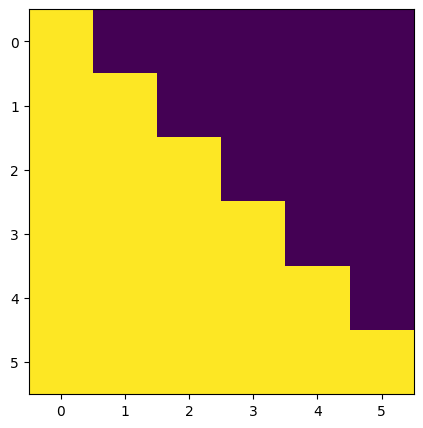

In [96]:
class Decoder(nn.Module):
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)


# 创建DecoderLayer，由self-attn, src-attn和feed forward构成
class DecoderLayer(nn.Module):
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)

    def forward(self, x, memory, src_mask, tgt_mask):
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)


# 构建上三角掩膜矩阵
def subsequent_mask(size):
    """Mask out subsequent positions."""
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0


#----------绘制掩膜矩阵图------------#
plt.figure(figsize=(5, 5))
plt.imshow(subsequent_mask(6)[0])
plt.savefig('mask.png')

### 8. 输入数据

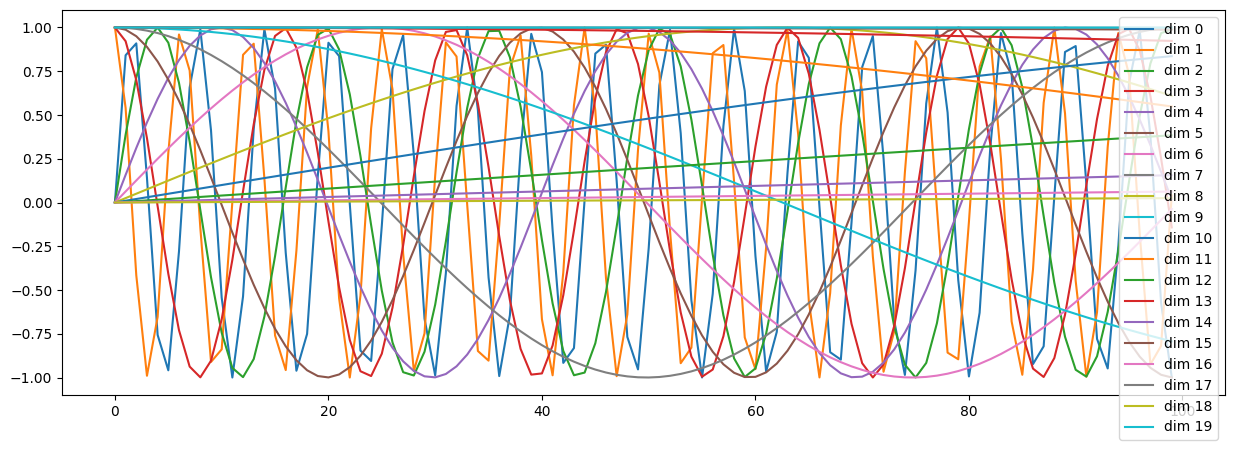

In [97]:
# 词嵌入
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)  #vocab为词表大小
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)


# 位置编码
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        # 在对数空间中计算，保证数值稳定性
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)].clone().detach()
        return self.dropout(x)


#----------绘制位置编码图------------#
## 语句长度为100，假设d_model=20，
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(torch.zeros(1, 100, 20))

plt.plot(np.arange(100), y[0, :, :].data.numpy())
plt.legend(["dim %d" % p for p in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]])

plt.savefig('positioncode.png')

# 9. 构建完整网络

In [98]:
def make_model(src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1):
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = Transformer(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn),
                             c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab))
    return model

# 测试一个简单模型，输入、目标语句长度分别为10，Encoder、Decoder各2层。
if __name__ == '__main__':
    model = make_model(11, 11, N=2)
    src = torch.LongTensor([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]])  # 本质上是一个索引向量
    src_mask = torch.ones(1, 1, 10)
    torch.onnx.export(model, (src, src, src_mask, src_mask), 'transformer.onnx')
    print(model)

C:\Users\hjs\AppData\Local\Temp\ipykernel_21660\1796886616.py:4: TracerWarning: Converting a tensor to a Python float might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)


Transformer(
  (encoder): Encoder(
    (layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0-3): 4 x Linear(in_features=512, out_features=512, bias=True)
          )
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward): PositionwiseFeedForward(
          (w_1): Linear(in_features=512, out_features=2048, bias=True)
          (w_2): Linear(in_features=2048, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (sublayer): ModuleList(
          (0-1): 2 x SublayerConnection(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
    )
    (norm): LayerNorm()
  )
  (decoder): Decoder(
    (layers): ModuleList(
      (0-1): 2 x DecoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0-3): 4 x Linear(in_features=512, out_fea